**Disclaimer**: this notebook's compatibility with StatsBomb event data 4.0.0 was last checked on January 22, 2020

In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import tqdm

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
import socceraction.spadl as spadl
import socceraction.spadl.statsbomb as statsbomb
import atomic.atomic_spadl as atomic

## Set up the statsbombloader

In [3]:
# Use this if you only want to use the free public statsbomb data
free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
SBL = statsbomb.StatsBombLoader(root=free_open_data_remote,getter="remote")

# # Uncomment the code below if you have a local folder on your computer with statsbomb data
#datafolder = "../data-epl" # Example of local folder with statsbomb data
#SBL = statsbomb.StatsBombLoader(root=datafolder,getter="local")

## Select competitions to load and convert

In [4]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{"FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 "Women's World Cup"}

In [5]:
# Fifa world cup
selected_competitions = competitions[competitions.competition_name=="FIFA World Cup"]

# # Messi data
# selected_competitions = competitions[competitions.competition_name=="La Liga"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name=="FA Women's Super League"]
selected_competitions

,competition_gender,competition_id,competition_name,country_name,match_available,match_updated,season_id,season_name
2,male,43,FIFA World Cup,International,2019-12-16T23:09:16.168756,2019-12-16T23:09:16.168756,3,2018


In [6]:
# Get matches from all selected competitions
matches = list(
    SBL.matches(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
)
matches = pd.concat(matches, sort=True).reset_index(drop=True)
matches[["home_team_name","away_team_name","match_date","home_score","away_score"]]

,home_team_name,away_team_name,match_date,home_score,away_score
0,Australia,Peru,2018-06-26,0,2
1,Nigeria,Iceland,2018-06-22,2,0
2,Serbia,Brazil,2018-06-27,0,2
3,Croatia,Denmark,2018-07-01,1,1
4,Iran,Portugal,2018-06-25,1,1
5,Mexico,Sweden,2018-06-27,0,3
6,Brazil,Costa Rica,2018-06-22,2,0
7,Germany,Mexico,2018-06-17,0,1
8,Portugal,Spain,2018-06-15,3,3
9,Russia,Egypt,2018-06-19,3,1


## Load and convert match data

In [7]:
matches_verbose = tqdm.tqdm(list(matches.itertuples()),desc="Loading match data")
teams,players,player_games = [],[],[]
actions = {}
atomic_actions = {}
for match in matches_verbose:
    # load data
    teams.append(SBL.teams(match.match_id))
    players.append(SBL.players(match.match_id))
    events = SBL.events(match.match_id)
    
    # convert data
    player_games.append(statsbomb.extract_player_games(events))
    actions[match.match_id] = statsbomb.convert_to_actions(events,match.home_team_id)
    atomic_actions[match.match_id] = atomic.convert_to_atomic(actions[match.match_id])

games = matches.rename(columns={"match_id":"game_id"})
teams = pd.concat(teams).drop_duplicates("team_id").reset_index(drop=True)
players = pd.concat(players).drop_duplicates("player_id").reset_index(drop=True)
player_games = pd.concat(player_games).reset_index(drop=True)

Loading match data: 100%|██████████| 64/64 [02:11<00:00,  1.91s/it]


## Store converted spadl data in a h5-file

In [8]:
datafolder = "../data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created ")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players
    spadlstore["player_games"] = player_games
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]
        spadlstore[f"atomic_actions/game_{game_id}"] = atomic_actions[game_id]

    spadlstore["actiontypes"] = spadl.actiontypes_df()
    spadlstore["results"] = spadl.results_df()
    spadlstore["bodyparts"] = spadl.bodyparts_df()
    spadlstore["atomic_actiontypes"] = atomic.atomic_actiontypes_df()

Directory ../data-fifa created 


## Plot the spadl data
Extra library required: ```pip install matplotsoccer```

In [9]:
# Select England vs Belgium game at World Cup
with pd.HDFStore(spadl_h5) as spadlstore:
    games = spadlstore["games"].merge(spadlstore["competitions"])
    game_id = games[(games.competition_name == "FIFA World Cup") 
                  & (games.home_team_name == "Belgium")
                  & (games.away_team_name == "England")].game_id.values[0]
    
    actions = spadlstore[f"actions/game_{game_id}"]
    actions = (
        actions.merge(spadlstore["actiontypes"],how="left")
        .merge(spadlstore["results"],how="left")
        .merge(spadlstore["bodyparts"],how="left")
        .merge(spadlstore["players"],how="left")
        .merge(spadlstore["teams"],how="left")
    )
    
    atomic_actions = spadlstore[f"atomic_actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions.merge(spadlstore["atomic_actiontypes"],how="left")
        #.merge(spadlstore["results"],how="left")
        .merge(spadlstore["bodyparts"],how="left")
        .merge(spadlstore["players"],how="left")
        .merge(spadlstore["teams"],how="left")
    )

# use nickname if available else use full name
actions["player"] = actions[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
atomic_actions["player"] = atomic_actions[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)

2018-07-14 Belgium 2-0 England 4'


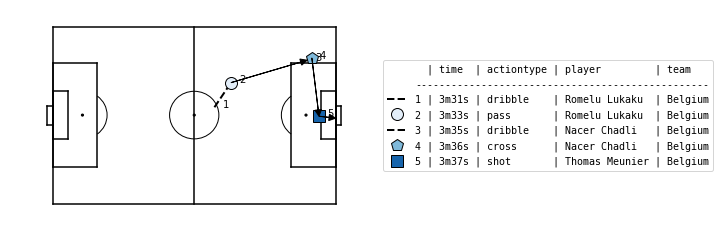

2018-07-14 Belgium 2-0 England 82'


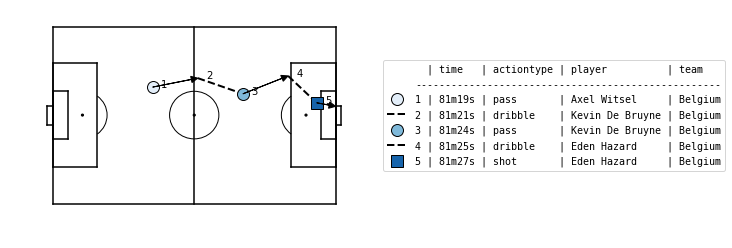

In [11]:
import matplotsoccer

for shot in list(actions[(actions.type_name == "shot") & (actions.result_name == "success")].index):
#shot = 124
    a = actions[shot-4:shot+1].copy()
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    minute = int((a.period_id.values[0]-1)*45 +a.time_seconds.values[0] // 60)
    game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1)*45 +row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        result= a.result_name == "success",
        label=labels,
        labeltitle=["time","actiontype","player","team"],
        zoom=False,
        figsize=6
    )
#     matplotsoccer.actions(
#         location=a[["start_x", "start_y", "end_x", "end_y"]],
#         action_type=a.type_name,
#         team=a.team_name,
#         result=a.result_name == "success",
#         label=labels,
#         labeltitle=["time","actiontype","player","team"],
#         zoom=40,
#     )

2018-07-14 Belgium 2-0 England 4'


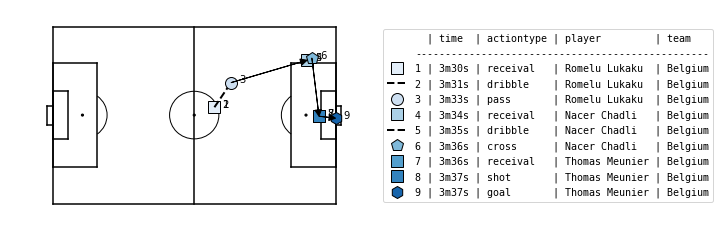

2018-07-14 Belgium 2-0 England 82'


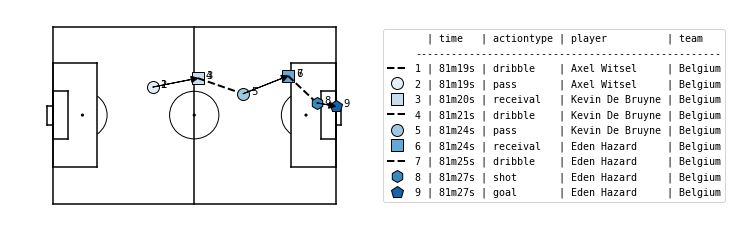

In [12]:
for shot in list(atomic_actions[(atomic_actions.type_name == "goal")].index):
    a = atomic_actions[shot-8:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    minute = int((a.period_id.values[0]-1)*45 +a.time_seconds.values[0] // 60)
    game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1)*45 +row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time","actiontype","player","team"],
        zoom=False,
        figsize=6
    )
#     matplotsoccer.actions(
#         location=a[["start_x", "start_y", "end_x", "end_y"]],
#         action_type=a.type_name,
#         team=a.team_name,
#         label=labels,
#         labeltitle=["time","actiontype","player","team"],
#         zoom=40,
#     )